In [17]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png',):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 


In [18]:
def load_ior_summary_list(json_file: Path):
    data = json.loads(json_file.read_text())
    return [
        {
            'Version': data['Version'],
            'Began': data['Began'],
            'Command line': data['Command line'],
            'Machine': data['Machine'],
            'Finished': data['Finished'],
            **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
            **{f"max_{k}": v for k, v in test["max"].items()},
            **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
            **{f"Options_{k}": v for k, v in test["Options"].items()},
            **{f'summary_{k}': v for k, v in data['summary'][index].items()},
            **{f'result_{k}': v for k, v in result.items()},
            'iorIteration': iteration,
        }
        for index, test in enumerate(data['tests'])
        for iteration, results in enumerate(test["Results"]) # iteration ?
        for result in results
    ]
# load_ior_summary_list(Path(f"../raw/{BENCHMARK_NAME}/2023.11.16-19.27.41/2023.11.16-20.03.19-92963.nqsv-bank-conflict-1/ior_summary_1.json"))


In [19]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [20]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    ("ior-pmembb/2024.01.23-15.20.41-default", {}),
    ("ior-pmembb/2024.01.23-15.22.18-default", {}),
    ("ior-pmembb/2024.01.24-12.44.18-default", {}), # remain 100 node job
    # ("ior-pmembb/2024.01.24-13.37.36-no-deferred-open", {}),
    # ("ior-pmembb/2024.01.24-15.43.39-no-deferred-open-1M", {}),
    ("ior-pmembb/2024.01.26-18.12.56-open-eval", {}),
    ("ior-pmembb/2024.01.26-18.14.06-open-eval", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

# def get_runtype(file: Path):
#     strpath = str(file.name)
#     if strpath.find("_r_l_") >= 0:
#         return "r_l"
#     elif strpath.find("_r_") >= 0:
#         return "r"
#     elif strpath.find("_w_") >= 0:
#         return "w"
#     else:
#         raise Exception

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for summary_file in job_dir.glob("ior_summary_*.json"):
            try:
                runid = get_runid(summary_file)
                # runtype = get_runtype(summary_file)
                job_summary_list = load_ior_summary_list(summary_file)
                job_params_file = job_dir / f"job_params_{runid}.json"
                job_params = json.loads(job_params_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"ior_stderr_{runid}.txt")
                for job_summary in job_summary_list:
                    src.append({
                        **default_metadata,
                        **metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **job_summary,
                        **pmembb_time,
                        "runid": runid,
                    })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{summary_file}, {e}')

df_src = (
    pd.DataFrame(src)
    .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
    .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
    .rename({
        "summary_bwMaxMIB": "bw",
        "summary_MeanTime": "time",
        "summary_segmentCount": "segmentCount",
        "summary_blockSize": "blockSize",
        "summary_transferSize": "transferSize",
        "summary_operation": "operation",
        "Parameters_filePerProc": "fpp",
        "Parameters_reorderTasks": "reorder",
        "summary_API": "api",
        "result_access": "access",
        "result_bwMiB": "bwMiB",
        "result_openTime": "openTime",
        "result_wrRdTime": "wrRdTime",
        "result_closeTime": "closeTime",
        "result_totalTime": "totalTime",
    }, axis=1)
    .astype({"fpp": bool, "reorder": bool,})
    .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
)
df_src["label"] = np.select([
    (df_src["access"] == "write"),
    (df_src["access"] == "read") & (df_src["reorder"] == True),
    (df_src["access"] == "read") & (df_src["reorder"] == False),
], ["Write", "Read (remote)", "Read (local)"])


df_src.head()


/work/0/NBB/hiraga/work/mpiio-pmembb/raw/ior-pmembb/2024.01.23-15.20.41-default/2024.01.24-09.00.05-166928.nqsv-100/ior_summary_13.json, Expecting value: line 1 column 1 (char 0)
/work/0/NBB/hiraga/work/mpiio-pmembb/raw/ior-pmembb/2024.01.26-18.14.06-default-open-eval/2024.01.26-18.58.55-167660.nqsv-16/ior_summary_0.json, Expecting value: line 1 column 1 (char 0)


,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,lustre_stripe_size,lustre_stripe_count,spack_env_name,Version,Began,Command line,Machine,Finished,test_TestID,test_StartTime,test_Path,test_Capacity,test_Used Capacity,test_Inodes,test_Used Inodes,max_readMiB,max_readMB,Parameters_testID,Parameters_refnum,Parameters_api,Parameters_platform,Parameters_testFileName,Parameters_hintsFileName,Parameters_deadlineForStonewall,Parameters_stoneWallingWearOut,Parameters_maxTimeDuration,Parameters_outlierThreshold,Parameters_options,Parameters_dryRun,Parameters_nodes,Parameters_memoryPerTask,Parameters_memoryPerNode,Parameters_tasksPerNode,Parameters_repetitions,Parameters_multiFile,Parameters_interTestDelay,Parameters_fsync,Parameters_fsyncperwrite,Parameters_useExistingTestFile,Parameters_showHints,Parameters_uniqueDir,Parameters_individualDataSets,Parameters_singleXferAttempt,Parameters_readFile,Parameters_writeFile,fpp,reorder,Parameters_reorderTasksRandom,Parameters_reorderTasksRandomSeed,Parameters_randomOffset,Parameters_checkWrite,Parameters_checkRead,Parameters_preallocate,Parameters_useFileView,Parameters_setAlignment,Parameters_storeFileOffset,Parameters_useSharedFilePointer,Parameters_useStridedDatatype,Parameters_keepFile,Parameters_keepFileWithError,Parameters_quitOnError,Parameters_verbose,Parameters_data packet type,Parameters_setTimeStampSignature/incompressibleSeed,Parameters_collective,Parameters_segmentCount,Parameters_transferSize,Parameters_blockSize,Options_api,Options_apiVersion,Options_test filename,Options_access,Options_type,Options_segments,Options_ordering in a file,Options_ordering inter file,Options_nodes,Options_tasks,Options_clients per node,Options_repetitions,Options_xfersize,Options_blocksize,Options_aggregate filesize,operation,api,summary_TestID,summary_ReferenceNumber,segmentCount,blockSize,transferSize,summary_numTasks,summary_tasksPerNode,summary_repetitions,summary_filePerProc,summary_reorderTasks,summary_taskPerNodeOffset,summary_reorderTasksRandom,summary_reorderTasksRandomSeed,bw,summary_bwMinMIB,summary_bwMeanMIB,summary_bwStdMIB,summary_OPsMax,summary_OPsMin,summary_OPsMean,summary_OPsSD,time,summary_xsizeMiB,access,bwMiB,result_blockKiB,result_xferKiB,result_iops,result_latency,openTime,wrRdTime,closeTime,totalTime,iorIteration,createTime,freeTime,loadTime,Options_task offset,max_writeMiB,max_writeMB,saveTime,odirect,strided,bwGB,label
0,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,8,/dev/dax0.0,0,2.12.9_ddn38,1048576,1,mpiio-pmembb,3.3.0,Wed Jan 24 01:23:16 2024,ior -a MPIIO -l timestamp -g -G -1401473791 -k...,Linux bnode001,Wed Jan 24 01:23:29 2024,0,Wed Jan 24 01:23:16 2024,/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,100.0 TiB,72.3%,5682.7 Mi,3.4%,4.901099e+06,5.139175e+06,0,0,MPIIO,bnode(Linux),/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,(null),0,0,0,0,(null),0,64,0,0,48,1,0,0,1,0,0,0,0,0,0,1,0,False,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,t,-1401473791,0,1,524288,21474836480,MPIIO,(3.1),/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,single-shared-file,independent,1,sequential,no tasks offsets,64,3072,48,1,524288 bytes,20 GiB,60 TiB,read,MPIIO,0,0,1,21474836480,524288,3072,48,1,0,0,1,0,0,4.901099e+06,4.901099e+06,4.901099e+06,0.0,9.802198e+06,9.802198e+06,9.802198e+06,0.0,12.8368,62914560.0,read,4.901099e+06,20971520.0,512.0,9.995467e+06,0.0003,0.2317,12.5886,0.0486,12.8368,0,16.614,0.052,0.016,NaN,NaN,NaN,NaN,False,False,5139.174919,Read (local)
1,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,10,/dev/dax0.0,0,2.12.9_ddn38,1048576,1,mpiio-pmembb,3.3.0,Wed Jan 24 01:27:42 2024,ior -a MPIIO -l timestamp -g -G -1401473791 -k...,Linux bnode001,Wed Jan 24 01:28:25 2024,0,Wed Jan 24 01:27:42 2024,/work/0/NBB/hiraga/work/mpiio-pmembb/backend/i...,100.0 TiB,72.3%,5682.7 Mi,3.4%,1.470221e+06,1.541639e+06,0,0,MPIIO,bnode(Linux),/work/0/NBB/hiraga/work/mpiio-

In [21]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "spack_env_name",
        "nnodes",
        # "segmentCount",
        # "blockSize",
        "transferSize",
        "lustre_stripe_count",
        "api",
        "label",
        "access",
        "reorder",
        "bwGB",
        "openTime",
        "wrRdTime",
        "closeTime",
        "totalTime",
        "createTime",
        "freeTime",
        "loadTime",
        "saveTime",
        "loadTime",
    ]]
    .head()
)


,spack_env_name,nnodes,transferSize,lustre_stripe_count,api,label,access,reorder,bwGB,openTime,wrRdTime,closeTime,totalTime,createTime,freeTime,loadTime,saveTime,loadTime
0,mpiio-pmembb,64,524288,1,MPIIO,Read (local),read,False,5139.174919,0.2317,12.5886,0.0486,12.8368,16.614,0.052,0.016,NaN,0.016
1,mpiio-pmembb,64,262144,1,MPIIO,Read (remote),read,True,1541.638842,0.3018,42.4550,0.0383,42.7926,16.154,0.024,0.015,NaN,0.015
2,mpiio-pmembb,64,2097152,1,MPIIO,Write,write,False,1562.943721,0.3964,41.7731,0.0639,42.2093,16.242,0.068,NaN,0.016,NaN
3,mpiio-pmembb,64,1048576,1,MPIIO,Read (local),read,False,4990.550762,0.4269,12.7469,0.0357,13.2191,16.663,0.055,0.016,NaN,0.016
4,mpiio-pmembb,64,2097152,1,MPIIO,Read (remote),read,True,1540.631507,0.3080,42.5002,0.0419,42.8206,16.269,0.024,0.012,NaN,0.012


<Axes: xlabel='spack_env_name,nnodes,access,reorder,label,transferSize,lustre_stripe_count'>

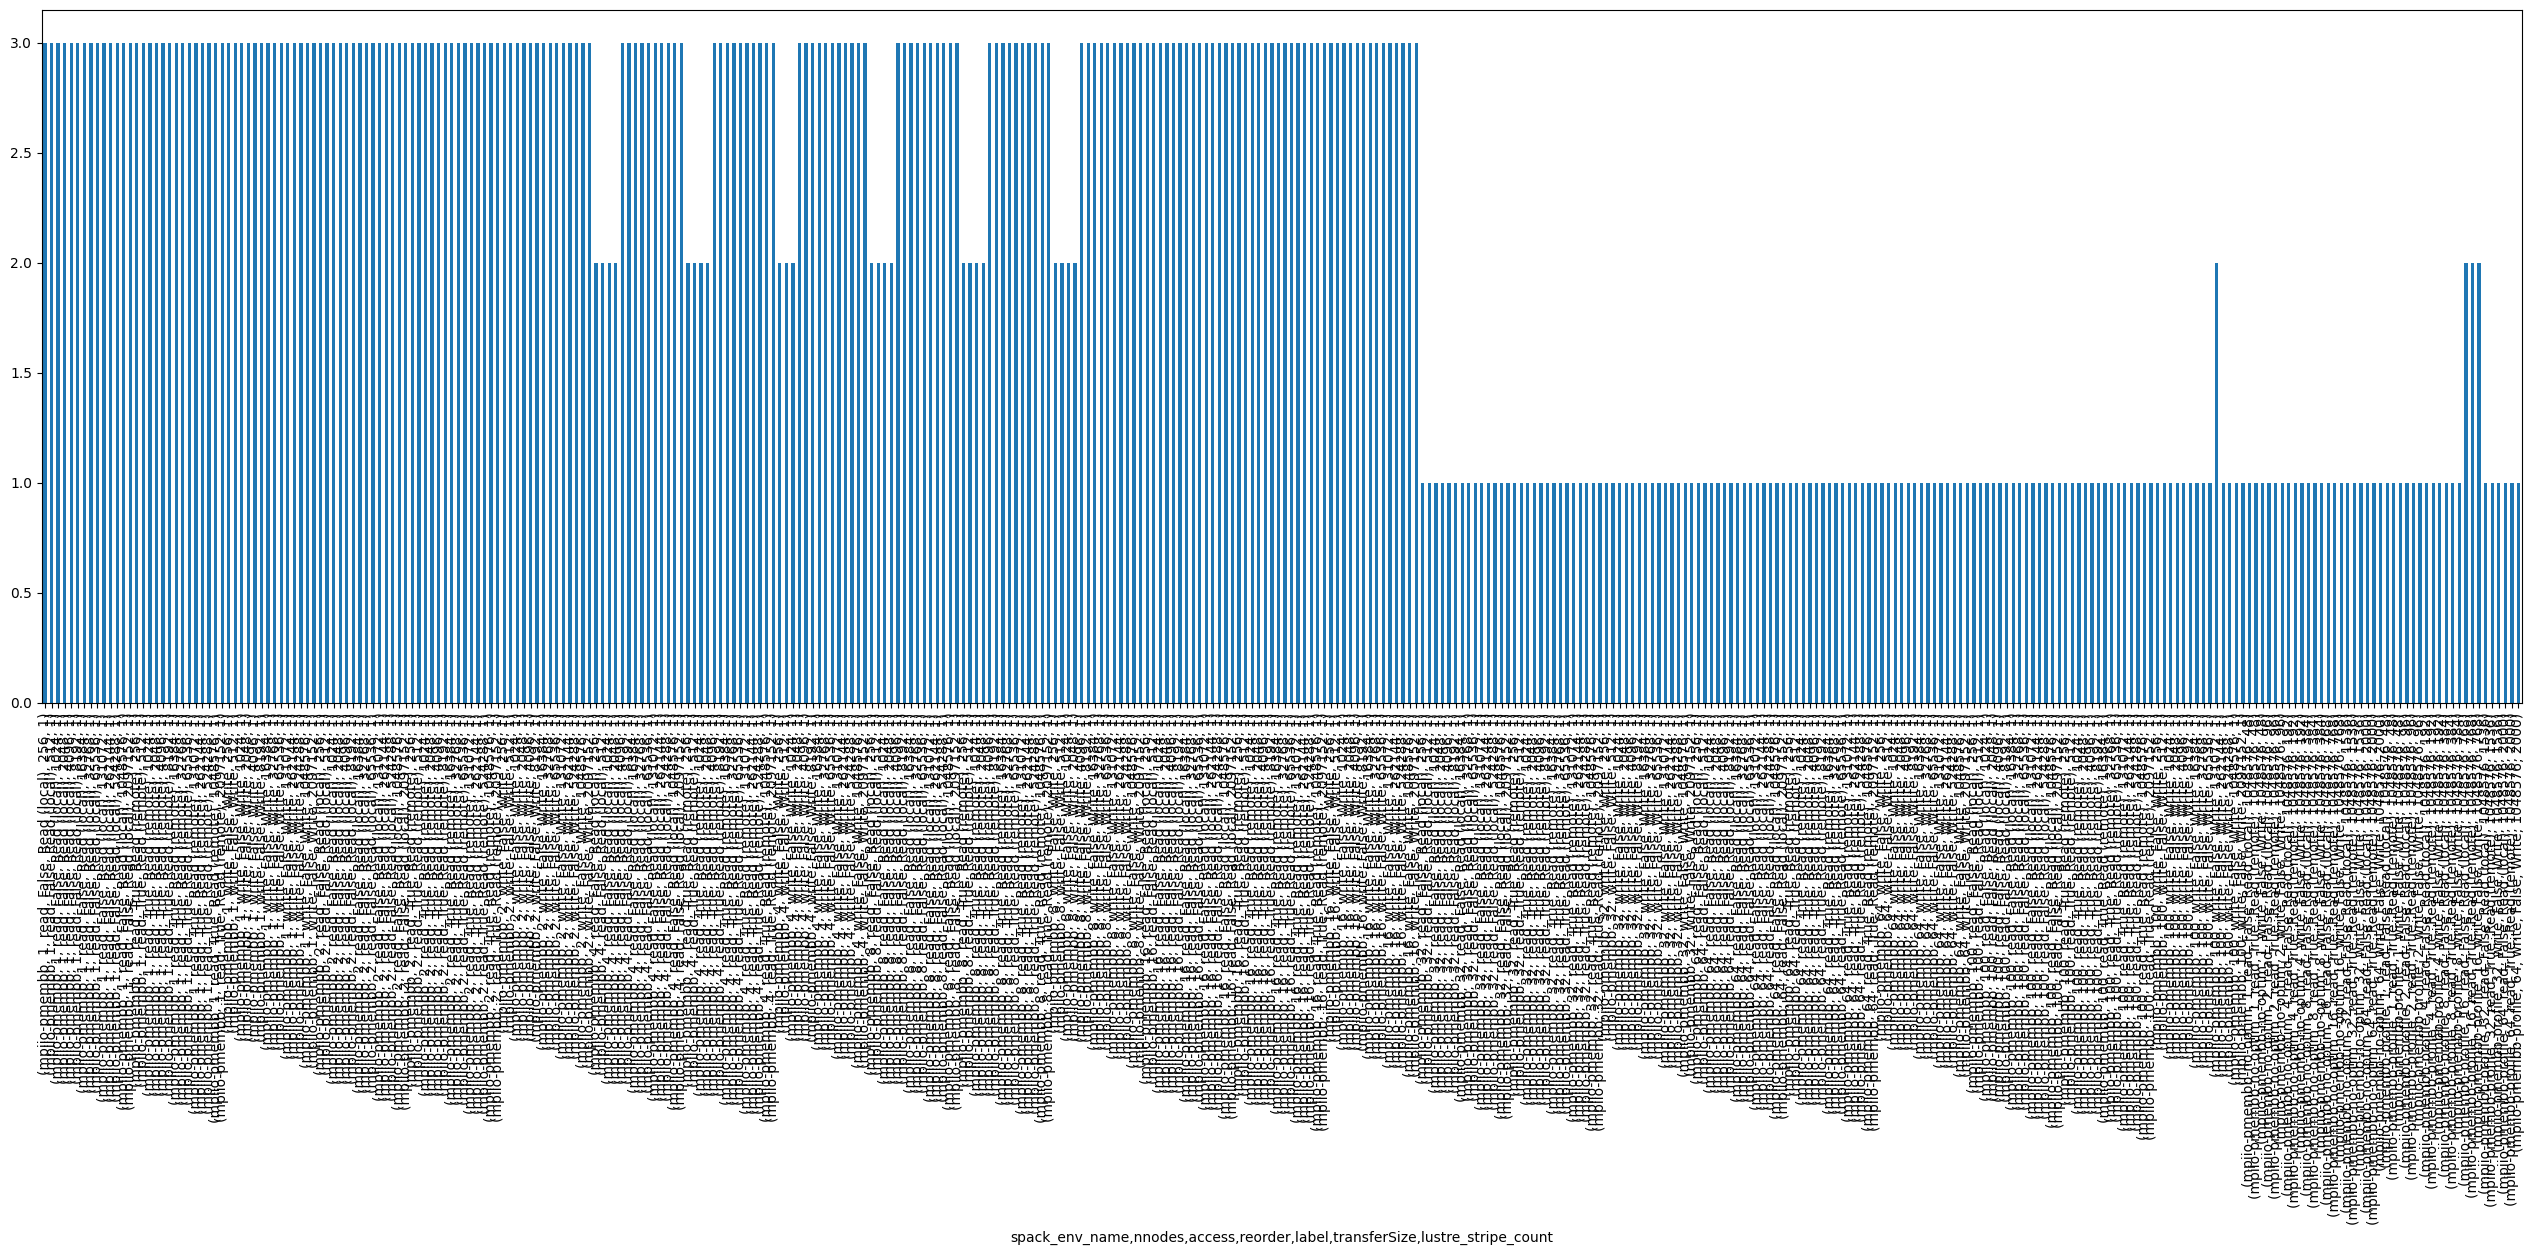

In [22]:
df = df_src
same_setting_columns = [
    "spack_env_name", "nnodes", "access", "reorder", "label", "transferSize", "lustre_stripe_count"]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


In [23]:
{
  "mpiio-pmembb": "+deferred_open",
  "mpiio-pmembb-deferred-open": "+deferred_open",
  "mpiio-pmembb-agg-read": "baseline",
  "mpiio-pmembb-no-optim": "baseline",
}

{'mpiio-pmembb': '+deferred_open',
 'mpiio-pmembb-deferred-open': '+deferred_open',
 'mpiio-pmembb-agg-read': 'baseline',
 'mpiio-pmembb-no-optim': 'baseline'}

In [24]:

time_columns = ["openTime", "wrRdTime"]
same_setting_grouper[time_columns].mean().reset_index().query(f"access == 'write' and transferSize == {2**20}")

,spack_env_name,nnodes,access,reorder,label,transferSize,lustre_stripe_count,openTime,wrRdTime
40,mpiio-pmembb,1,write,False,Write,1048576,1,0.019900,41.298767
82,mpiio-pmembb,2,write,False,Write,1048576,1,0.139367,41.394133
124,mpiio-pmembb,4,write,False,Write,1048576,1,0.082100,41.585667
166,mpiio-pmembb,8,write,False,Write,1048576,1,0.145133,41.963600
208,mpiio-pmembb,16,write,False,Write,1048576,1,0.205900,42.259600
250,mpiio-pmembb,32,write,False,Write,1048576,1,0.300700,42.195700
292,mpiio-pmembb,64,write,False,Write,1048576,1,0.362100,42.327400
334,mpiio-pmembb,100,write,False,Write,1048576,1,0.358600,42.372800
338,mpiio-pmembb-no-optim,1,write,False,Write,1048576,48,0.172600,41.997900
341,mpiio-pmembb-no-optim,2,write,False,Write,1048576,96,0.078900,41.227600


read


'+deferred_open'

,openTimeMS
nnodes,
2,33.0
4,129.9
8,419.0
16,270.2
32,275.4
64,378.1


'baseline'

,openTimeMS
nnodes,
2,55.9
4,92.4
8,129.0
16,189.0
32,325.5
64,326.1


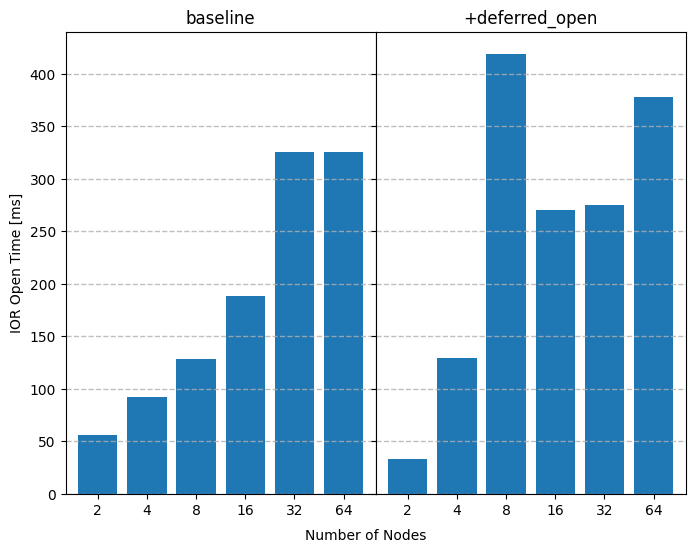

write


'+deferred_open'

,openTimeMS
nnodes,
1,74.3
2,63.2
4,157.1
8,141.3
16,392.0
32,404.4
64,413.4


'baseline'

,openTimeMS
nnodes,
1,172.6
2,78.9
4,145.8
8,230.7
16,469.7
32,1547.1
64,4619.2


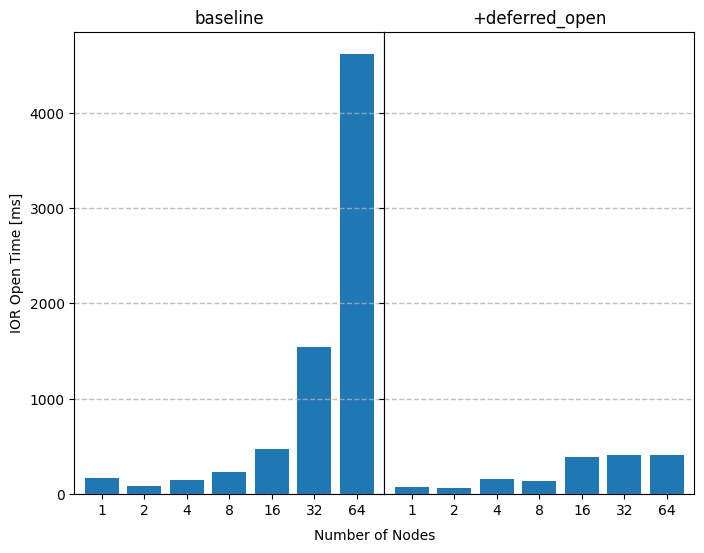

In [25]:
env_to_label = {
  "mpiio-pmembb": "+deferred_open",
  "mpiio-pmembb-deferred-open": "+deferred_open",
  "mpiio-pmembb-agg-read": "baseline",
  "mpiio-pmembb-no-optim": "baseline",
  "mpiio-pmembb-profile": "+deferred_open"
}

time_columns = ["openTime", "wrRdTime", "closeTime", "totalTime", "createTime", "loadTime", "saveTime", "freeTime"]

df = (
    same_setting_grouper
    [time_columns]
    .max()
    .reset_index()
    .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    .assign(optim=lambda x: x["spack_env_name"].apply(lambda y: env_to_label[y]))
    .query(f"lustre_stripe_count != 1")
    .query(f"not (access == 'read' and reorder == True and nnodes == 1) and not (access == 'read' and reorder == False) and transferSize == {2**20} and nnodes <= 64")
    .fillna(0.)
)
# df

for timec in time_columns:
    df[f"{timec}MS"] = df[timec] * 1000

for (access, ), df_access in df.groupby(["access"]):
    print(access)
    # if access == "write":
        # time_values = ["createTime", "openTime", "wrRdTime", "closeTime", "saveTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    # else:
        # time_values = ["createTime", "loadTime", "openTime", "wrRdTime", "closeTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    time_values = ["openTimeMS"]

    fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    fig.subplots_adjust(hspace=0, wspace=0)

    for idx, ((optim, ), df_sub) in enumerate(df_access.groupby(["optim"])):
        # display(df_sub)
        df_plot = (
            df_sub
            .set_index("nnodes")
            [time_values]
            # .loc[["baseline", "+deferred_open"], :]
        )
        display(optim, df_plot)

        # fig = plt.figure(figsize=(8, 6), dpi=100)
        # fig.patch.set_alpha(1)
        ax = df_plot.plot(
            ax=axs[(idx+1)%2],
            kind="bar",
            stacked=True,
            xlabel="",
            ylabel="IOR Open Time [ms]",
            # style=".-",
            legend=None,
            rot=0,
            width=0.8,
        )
        ax.set_title(f"{optim}")
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))


    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles=handles[::-1], labels=labels[::-1], loc="upper right", bbox_to_anchor=(0.99, 0.89))#, borderaxespad=0.)
    
    fig.text(0.5, 0.04, "Number of Nodes", ha="center", va="center")

    fig.show()
    plt.show()
    save(fig, F"ior_deffered_open_{access}")

transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,
1,59.937796,69.043245,68.590326,69.465175,76.338659,80.478184,81.830313,82.759076,82.921406,83.200613,83.491632,83.593321,82.650955,72.410097
2,119.938596,139.482530,140.211936,140.756915,154.256532,162.822235,166.431911,167.684872,169.125535,169.882509,168.711783,169.819335,168.095379,147.117471
4,234.150514,268.633205,275.360832,275.415709,299.782369,317.136574,321.370639,325.069035,326.613110,327.803015,328.201745,328.375277,326.189937,284.807355
8,464.785043,537.723202,545.967425,552.347780,597.861130,626.206973,635.562124,648.126400,649.463634,654.396892,651.531949,651.082264,645.097860,566.031306
16,911.391293,1068.261470,1083.172753,1086.242740,1189.896360,1256.471741,1268.877118,1283.556422,1283.088861,1276.106926,1293.216576,1303.361282,1281.268593,1115.760961
32,1811.834229,2109.782500,2152.598944,2141.145805,2337.090638,2486.218370,2463.978950,2546.018171,2545.860828,2510.047941,2544.071139,2550.720071,2548.126221,2209.531380
64,3624.566264,4213.781161,4280.375483,4293.161774,4662.839176,4892.790739,5010.175516,5073.063752,5030.160458,4818.607626,5102.304544,5139.174919,4990.550762,4400.692407
100,5479.364182,6442.494305,6530.482860,6772.440746,7039.808650,7424.626788,7527.117014,7686.149692,7740.061536,7750.595630,7617.305227,7722.492855,7531.998260,6698.951860


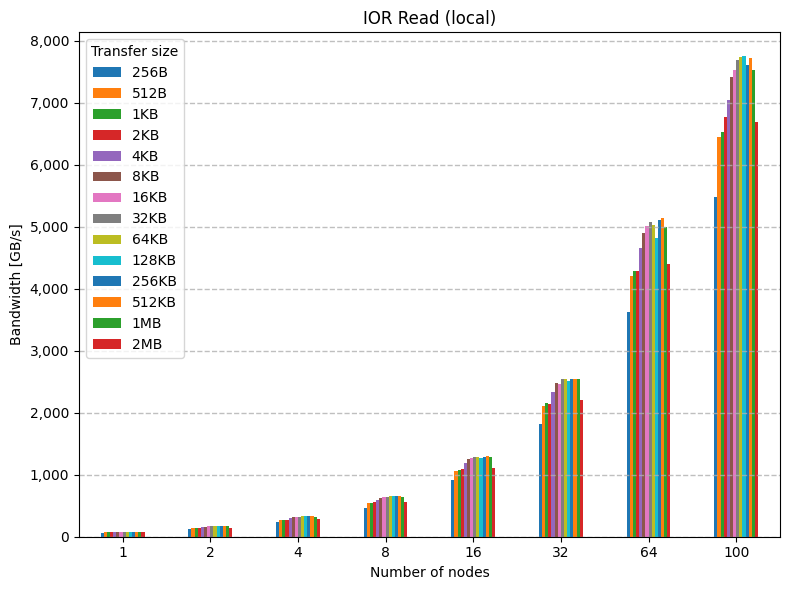

transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,
2,4.887663,9.309238,17.252629,31.216620,44.116229,47.178962,47.957393,48.437253,48.522570,48.568824,48.548412,48.580417,48.577650,48.578961
4,9.196967,17.511601,27.819040,55.099902,86.048086,94.261050,95.743169,96.725825,96.025318,96.939422,97.089789,96.910504,96.951911,96.945178
8,16.257175,30.837754,52.315632,101.281132,171.186583,187.906674,191.444053,193.212062,191.722674,193.701077,193.858457,193.848517,193.775742,193.637612
16,35.857595,68.024477,108.352224,218.958258,342.805684,375.345327,382.671262,386.295563,384.274221,386.941289,386.758058,387.072398,386.819969,386.882161
32,61.436965,116.414096,192.563174,383.170215,636.516599,736.027829,759.598960,769.056710,766.485555,768.784026,773.253691,772.035052,771.867374,770.055386
64,122.353868,232.120670,383.284577,772.236503,1279.679655,1489.254594,1522.365739,1537.975750,1524.865183,1539.120074,1541.638842,1537.505153,1540.232576,1540.631507
100,192.169223,365.171100,605.677897,1179.059970,1960.132553,2290.634927,2344.225928,2382.250783,2359.441943,2379.961711,2387.744699,2384.772966,2381.713974,2385.701405


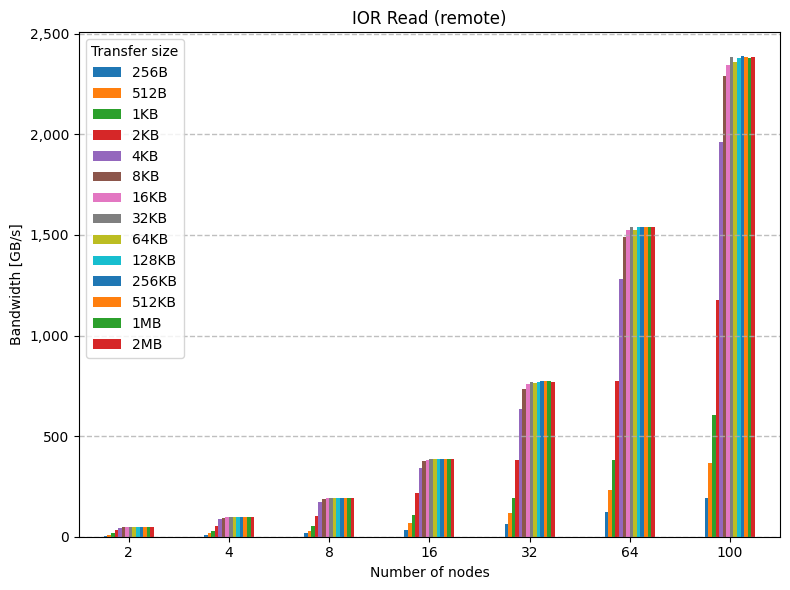

transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,
1,26.309229,26.470330,26.261931,26.210188,25.861533,25.107555,25.016613,24.969357,25.060271,24.991053,25.017081,24.987864,25.016087,25.594842
2,52.662124,52.864778,52.591439,52.308009,51.740618,50.263043,50.051812,49.739472,50.117499,49.972404,50.045342,49.983904,49.800519,51.164929
4,102.783174,102.664157,102.667894,103.653041,102.497893,99.700032,99.313193,99.027769,99.604441,99.354583,99.270554,99.244070,99.503459,101.575146
8,197.806874,199.337269,199.326204,200.393265,201.975732,197.858709,194.981057,196.817743,197.690614,197.231901,197.348567,197.349616,197.149034,201.308884
16,394.192824,396.783696,398.384713,398.962319,396.062140,389.704063,389.283534,388.792888,389.390406,389.563799,388.621930,389.222869,389.262743,394.061112
32,787.182607,792.990882,797.220423,799.270147,794.042560,778.365695,773.940748,776.469187,776.741828,774.380148,775.142041,776.522630,775.872119,790.893819
64,1557.042196,1582.708532,1588.982252,1594.014120,1577.847059,1547.341789,1546.420566,1540.161204,1546.250892,1543.979352,1536.456955,1543.428012,1544.112552,1562.943721
100,2401.679537,2462.997753,2470.947638,2465.055903,2463.853422,2417.993880,2408.448315,2411.629479,2414.653564,2408.929476,2405.065374,2408.673904,2406.934527,2429.826425


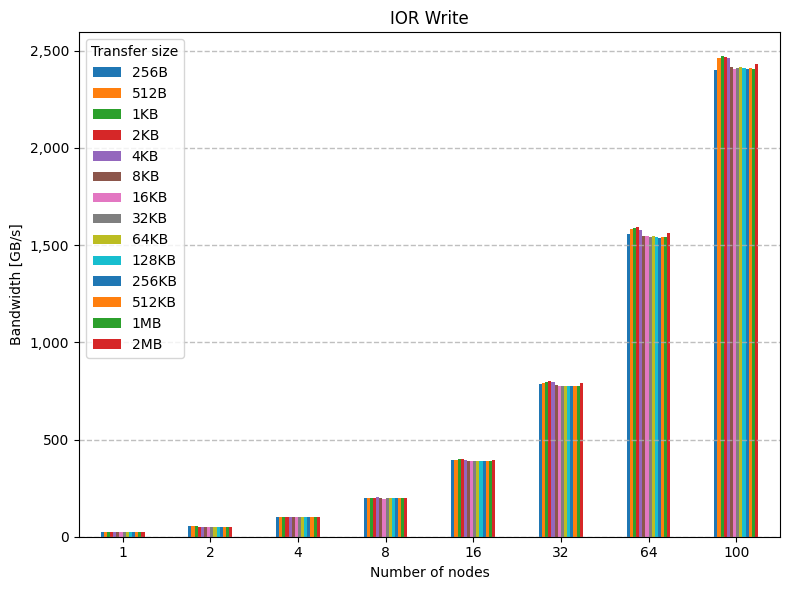

In [27]:
df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    .query("lustre_stripe_count == 1")
    .query("spack_env_name == 'mpiio-pmembb' and not (access == 'read' and reorder == True and nnodes == 1)")
)

for (access, reorder, label), df_sub, in df.groupby(["access", "reorder", "label"]):
    # for value in ["bw", "time"]:
    for value in ["bwGB"]:
        # df_plot = df_sub.pivot(index="transferSize", columns=["nnodes"], values=value)
        df_plot = df_sub.pivot(index="nnodes", columns=["transferSizeH"], values=value).loc[:, [pretty_fmt(256 * 2**x) for x in range(0, 14)]]

        display(df_plot)

        fig = plt.figure(figsize=(8, 6), dpi=100)
        fig.patch.set_alpha(1)

        ax = df_plot.plot(
            ax=fig.add_subplot(),
            kind="bar",
            # kind="line",
            # xlabel="Transfer size [B]",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]" if value == "bwGB" else "Elapsed time [sec]",
            # style=".-",
            rot=0,
        )
        ax.set_title(f"IOR {label}")
        # ax.set_xscale("log", base=2)
        # ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

        # legend_title = ax.get_legend().get_title().get_text()
        # ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        ax.legend(title="Transfer size")
        plt.tight_layout()

        fig.show()
        plt.show()
        save(fig, F"ior_{access}_{'remote' if reorder else 'local'}_{value}")
